### (2024) INTRODUCTORY SPATIAL 'OMICS ANALYSIS
#### HYBRID : TORONTO & ZOOM
### __________________________________________


#### 9TH JULY 2024 
Course materials prepared & taught by Shamini Ayyadhury

_______________________________________________________


### MODULE 2 - WRANGLING WITH YOUR DATA
#### A. UNDERSTANDING DATA OUTPUT
##### Review of standard output files and file paths
*** the files we will be using in this workshop

01. analysis_summary.html
02. analysis.tar
03. analysis.zarr.zip
04. cell_boundaries.csv 
05. cell_boundaries.parquet ***
06. cell_feature_matrix
07. cell_feature_matrix.h5 ***
08. cell_feature_matrix.tar
09. cell_feature_matrix.zarr.zip
10. cells.csv 
11. cells.parquet ***
12. cells.zarr.zip
13. experiment.xenium
14. gene_panel.json
15. metrics_summary.csv
16. morphology_focus.ome.tif
17. morphology_mip.ome.tif
18. morphology.ome.tif ***
19. nucleus_boundaries.csv
20. nucleus_boundaries.parquet ***
21. transcripts.csv
22. transcripts.parquet ***
23. transcripts.zarr.zip


#### B. PRE-PROCESSING YOUR DATA
In this section participants will review the transcripts file. The transcripts file contains the identity, position of each transcript from genes and controls. Here we will start from this file and review the quality values and assess cut-off margins. 

OBJECTIVES
###### 1. Process transcript file and evaluate quality of gene and control transcripts
###### 2. Assess the distribution of transcripts across 'field of view'.
###### 3. Derive the gene matrix, counts matrix and cell centroid matrix from the transcript file

DATASETS WE WILL USE
###### 1. We will use the FFPE half-brain xenium sample - "TgCRND8 17.9 months" for this first script
This is a transgenic mouse model for Alzheimer's disease pathology
"https://www.10xgenomics.com/datasets/xenium-in-situ-analysis-of-alzheimers-disease-mouse-model-brain-coronal-sections-from-one-hemisphere-over-a-time-course-1-standard"


* We will be using some packages routinely throughput this workshop. 
* Wrapper functions are provided where necessary.
    * The reason being, the purpose of this workshop is not to bias anyone towards any standard or popular packages but to deliver an understanding as to what is happenning.
    * There are multiple different tools out there and the purpose of this workshop is to give you the necessary knowledge to understand what is happenning under the hood.

In [1]:
### import the following libraries

### Packages for general system functions, miscellaneous operating system interfaces, warning control system
import sys ### general system functions
import os ### miscellaneous operating system interfaces
import warnings ### warning control system
import psutil
warnings.filterwarnings('ignore') ### ignore warnings

### Packages for data manipulation and analysis, data visualization
import pandas as pd ### data manipulation and analysis for tabular data in python
import matplotlib.pyplot as plt ### plotting library for the Python programming language and its numerical mathematics extension NumPy
import seaborn as sns ### data visualization library based on matplotlib (my personal favourite over matplotlib)
from PIL import Image ### python imaging library




In [2]:
"""
The "pre_processing_fnc" is a custom python script that contains all the functions required for pre-processing the data.
These are wrapper functions written specifically for this workshop to help participants understand the pre-processing steps and to save time.
This package is available in the "spatial_workshop" repository where participants are encouraged to look at the exact codes and scripts after lessons.

The functions in this script include:

1. check_parquet
Sometimes, there is an issue when loading .parquet files, the string values end up as bytes. This function checks for this issue and fixes it.

2. process_data
This function will label the transcripts as gene or control and as assigned to a cell or not

3. clean_processed_tf
This function will remove low quality transcripts and give 4 matrices as output: gene matrix file, control matrix file, counts matrix and cell centroid matrix

4. process_adata
8. prepare_adata
This wrapper will process the centroid matrix, gene matrix and counts matrix properlt to create anndata object

5. fov_plot
A function to plot the field of view (FOV) images that saves time for participants to visualize the data.

6. plot_gene_and_neg_transcripts
Another function to plot the gene and negative transcripts and assess their QV values that saves time for participants to visualize the data.

7. display_side_by_side

An image plotting wrapper

"""

sys.path.append('/home/shamini/anaconda3/envs/xenium/lib/python3.10/site-packages/')
sys.path.append('/home/shamini/data/projects/spatial_workshop/')

import pre_processing_fnc as ppf

In [3]:
### its sometimes useful to assign the file names or paths to variables to avoid typing errors

### path variables
data_dir = '/home/shamini/data1/data_orig/data/spatial/xenium/10xGenomics/' ### data directory
out = '/home/shamini/data/projects/spatial_workshop/out/module2/' ### output directory for saving files. We have created these output directories in advance to save time. Participants are free to create their own if they wish to.
os.makedirs(out+'script01_figures/', exist_ok=True) ### create a new directory for saving figures (but checks if the directory already exists)


### object variables
datasets_to_use = 'mice_AD_model/TgCRND8/xenium_out/' ### the name of the dataset to use
features_filepath = 'cell_feature_matrix.h5'
cells_filename = 'cells.parquet'
transcripts_filename = 'transcripts.parquet'
metrices_filename = 'metrics_summary.csv'

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 287.34 MB'

In [4]:

### we will load 3 files here: cell_feature_matrix.h5, cells.parquet and transcripts.parquet
### We will check the parquet file to ensure that the string values are not in bytes format and if they are to convert them back to string
df_cell = ppf.check_parquet(os.path.join(data_dir+datasets_to_use ,cells_filename))
df_transcript = ppf.check_parquet(os.path.join(data_dir+datasets_to_use, transcripts_filename))
df_metric = pd.read_csv(os.path.join(data_dir+datasets_to_use, metrices_filename))

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 4008.79 MB'

In [5]:
df_transcript

### Look at the transcript dataframe and what do you see? What are the columns? What are the values? What are the data types?
### Which columns are important for our analysis? 
### What is fov?


,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance
0,281474976710656,UNASSIGNED,0,Sox10,164.488159,26.783148,11.713852,6.386437,A1,0.000000
1,281474976710657,UNASSIGNED,0,Ctsh,169.854828,652.652710,11.551014,27.915363,A1,0.000000
2,281474976710658,UNASSIGNED,0,Ntng1,260.067108,483.239105,12.582438,15.282572,A1,158.240051
3,281474976710659,UNASSIGNED,0,Ntng1,269.161957,409.500854,14.335079,29.190599,A1,84.092049
4,281474976710660,UNASSIGNED,0,Ntng1,272.351532,406.806152,15.083600,23.004885,A1,80.833069
...,...,...,...,...,...,...,...,...,...,...
15687977,281754149588135,UNASSIGNED,0,Gja1,5409.146973,4595.415527,47.166138,40.000000,F9,249.485168
15687978,281754149588136,UNASSIGNED,0,Parm1,5409.084961,4545.690430,47.943249,40.000000,F9,209.809052
15687979,281754149588137,UNASSIGNED,0,Cryab,5422.902344,4718.045898,47.374062,40.000000,F9,363.675476
15687980,281754149588138,UNASSIGNED,0,Aldh1l1,5428.985840,4540.973633,47.546749,40.000000,F9,220.056595


Analyze transcript QC

In [6]:

"""
### The process_data function is a wrapper that does the following
1. The transcripts are derived from either gene or control probes
2. There are 3 different types of control probes : Negative codewords, Negative probes and Blank probes. The first two begin with Neg* and the last one begins with BLANK*
3. In this tutorial, we label all control probes as neg_probes and all gene-derived transcripts as gene_probes
4. We also label the transcripts as assigned to a cell or not assigned to a cell. Note this initial assigment is based from the cell segmentation from the standard xenium clear_output
"""

processed_data = ppf.process_data(df_transcript) ### we process and assign the output to an object called processed_data
del df_transcript ### we delete the original transcript dataframe to save memory

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 5220.51 MB'

In [7]:
processed_data.head()
### note the additional columns added to the processed_data dataframe : group and binary


,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,group,binary
0,281474976710673,UNASSIGNED,0,NegControlCodeword_0525,521.660461,136.843735,16.362139,6.256971,A1,71.458954,neg_probes,unassigned
1,281474976710948,aacjohgo-1,0,NegControlProbe_00022,529.004395,863.931335,18.672186,8.220678,A1,0.149207,neg_probes,assigned
2,281474976711186,bdllbmjb-1,1,BLANK_0079,631.065247,802.078064,17.320450,7.153158,A1,0.000000,neg_probes,assigned
3,281474976711425,befokmfj-1,0,NegControlCodeword_0522,621.046143,612.479370,18.231283,13.597658,A1,3.220134,neg_probes,assigned
4,281474976711532,bedcfobh-1,0,BLANK_0089,594.023499,648.976807,19.224051,7.155697,A1,8.566228,neg_probes,assigned


#### Now it is important to understand the quality of transcripts. 
* This is an image-based system. There are many facets of the experimental process that will affect the quality of the tissue.
* The purpose of "Module 1 : Garbage-in, Garbage-out" was to highlight this. 
* Therefore, review these steps carefully as it will help you identify if you need to "quarantine" certain regions from downstream processing steps.

B1. QUALITY ASSESSEMENT
* Lets look at some plots that will assess the quality of these imaged transcripts

'Memory usage: 6195.90 MB'

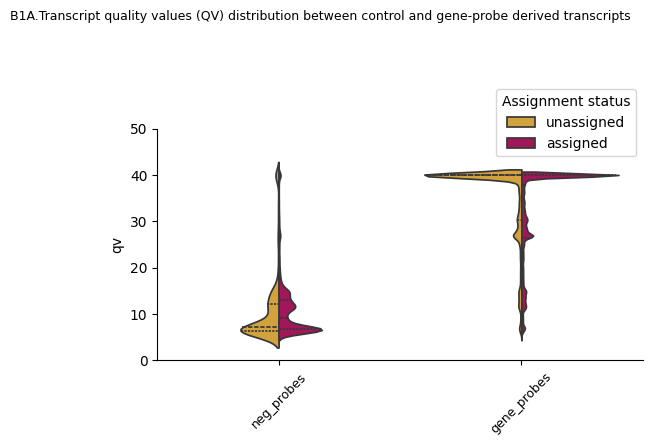

In [8]:

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

fig.suptitle('B1A.Transcript quality values (QV) distribution between control and gene-probe derived transcripts', fontsize=9)
sns.violinplot(x='group', y='qv', data=processed_data, hue='binary', split=True, inner='quartile', ax=ax, palette=['#ebac23', '#b80058'])
ax.set_ylim(0, 50)
ax.xaxis.set_tick_params(rotation=45, labelsize=9)
ax.set_xlabel('')
sns.despine()
plt.legend(title='Assignment status', loc='upper right', bbox_to_anchor=(1, 1.2))
plt.tight_layout(rect=[0, 0, 1.25, 0.95])
plt.savefig(out+'script01_figures/figure02_violinplot_qv.jpeg', dpi=300)

ppf.get_memory_usage() ### monitor memory usage

binary,assigned,unassigned
proportion,0.955743,0.044257
group,gene_probes,neg_probes
proportion,0.994364,0.005636
binary,assigned,unassigned
group,,
gene_probes,14911288,688272
neg_probes,82392,6030


'Memory usage: 6228.35 MB'

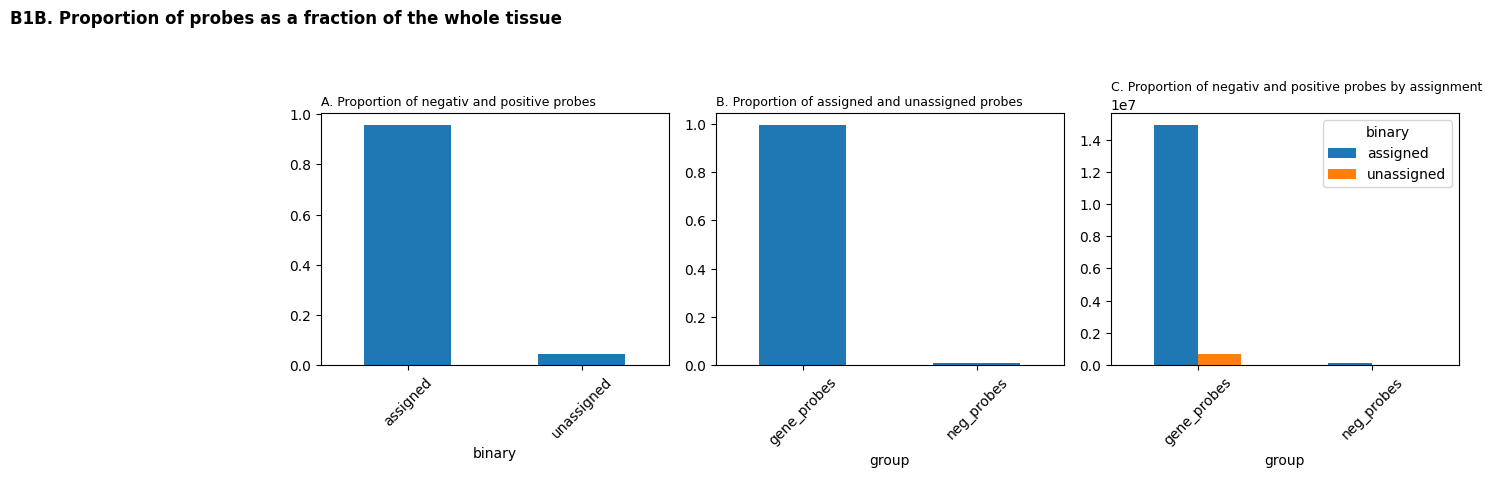

In [9]:
### plot the proportion of neg and positive probes and the proportion of assigned and unassigned probes
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))

fig.suptitle('B1B. Proportion of probes as a fraction of the whole tissue', fontsize=12, fontweight='bold', y=1.05, x=0.01)
ax = processed_data['binary'].value_counts(normalize=True).plot(kind='bar', ax=axes[0])
ax.set_title('A. Proportion of negativ and positive probes', fontsize=9, loc='left')
ax.xaxis.set_tick_params(rotation=45)

ax = processed_data['group'].value_counts(normalize=True).plot(kind='bar', ax=axes[1])
ax.set_title('B. Proportion of assigned and unassigned probes', fontsize=9, loc='left')
ax.xaxis.set_tick_params(rotation=45)

ax = processed_data.groupby(['group', 'binary']).size().unstack().plot(kind='bar', stacked=False, ax=axes[2])
ax.set_title('C. Proportion of negativ and positive probes by assignment', fontsize=9, loc='left')
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()
plt.savefig(out+'script01_figures/figure01_proportion_of_probes.jpeg', dpi=300)

### save the values above into a table for each sample
binary_proportion = processed_data['binary'].value_counts(normalize=True),
group_proportion = processed_data['group'].value_counts(normalize=True),
group_binary_proportion = processed_data.groupby(['group', 'binary']).size().unstack()

binary_proportion = pd.DataFrame(binary_proportion)
group_proportion = pd.DataFrame(group_proportion)
group_binary_proportion = pd.DataFrame(group_binary_proportion)

dfs = [binary_proportion, group_proportion, group_binary_proportion]
titles = ['Binary Proportion', 'Group Proportion', 'Group Binary Proportion']

ppf.display_side_by_side(dfs, titles)

ppf.get_memory_usage() ### monitor memory usage

* Now let's look at the quality value of transcripts as they are distributed across the tissue area.
* It is important to look at the distribution of your low and high quality transcripts as this reflects the underlying tissue "health" that can help guide further image processing or transcript inclusion.

'Memory usage: 7305.97 MB'

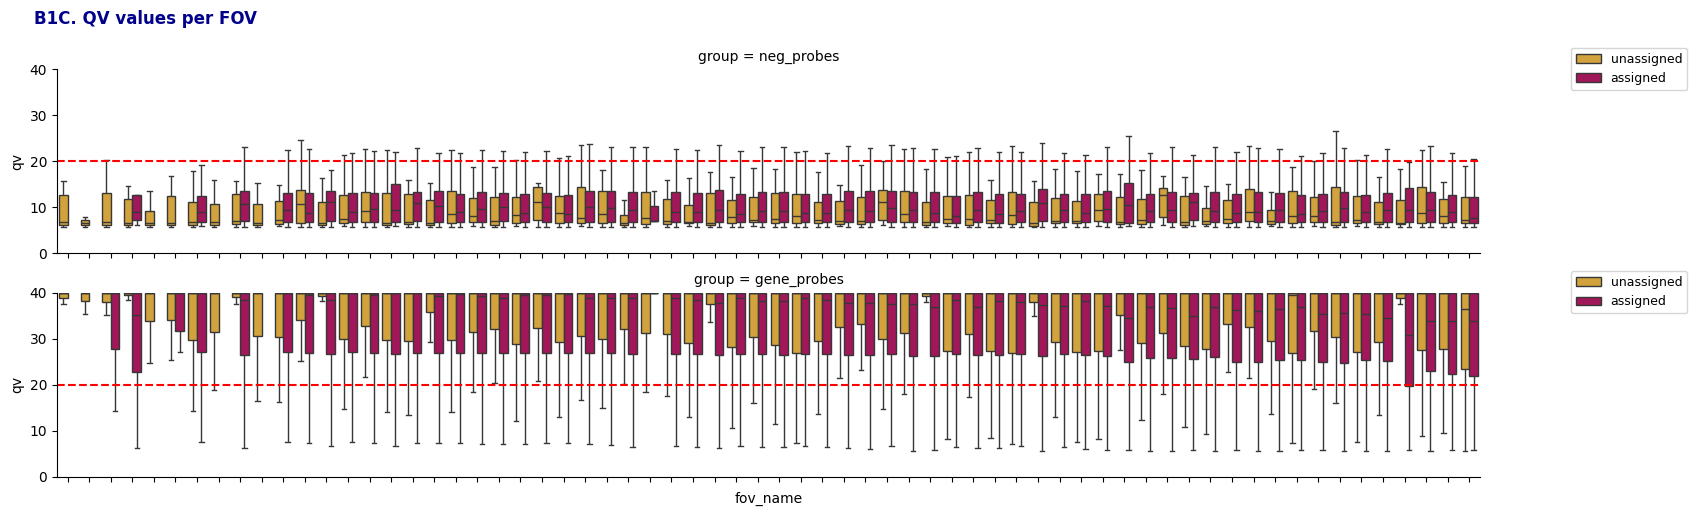

In [10]:
  

# Assuming processed_data is already defined and loaded as a DataFrame
# Reorder the fov_name based on the mean qv values

fov_mean = processed_data.groupby('fov_name')['qv'].mean().reset_index()
fov_mean = fov_mean.sort_values('qv', ascending=False)
processed_data['fov_name'] = pd.Categorical(processed_data['fov_name'], fov_mean['fov_name'])

# Plot directly into the axes
g = sns.FacetGrid(processed_data, col='group', col_wrap=1, height=2.5, aspect=6, sharey=True, sharex=True, despine=True)

# Mapping the boxplot
g.map_dataframe(sns.boxplot, x='fov_name', y='qv', hue='binary', palette=['#ebac23', '#b80058'], showfliers=False)

# Customize the FacetGrid
for ax in g.axes.flat:
    ax.set_ylim(0, 40)
    ax.axhline(20, color='red', linestyle='dashed')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=9, bbox_to_anchor=(1.15, 1.15))
    # Shift title to the left

# Remove the additional title
g.figure.suptitle('B1C. QV values per FOV', y=1.05, x=0.1, fontsize=12, fontweight='bold', color='darkblue')
plt.savefig(out+'script01_figures/figure03_boxplot_qv_per_fov.jpeg', dpi=300)

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 5341.77 MB'

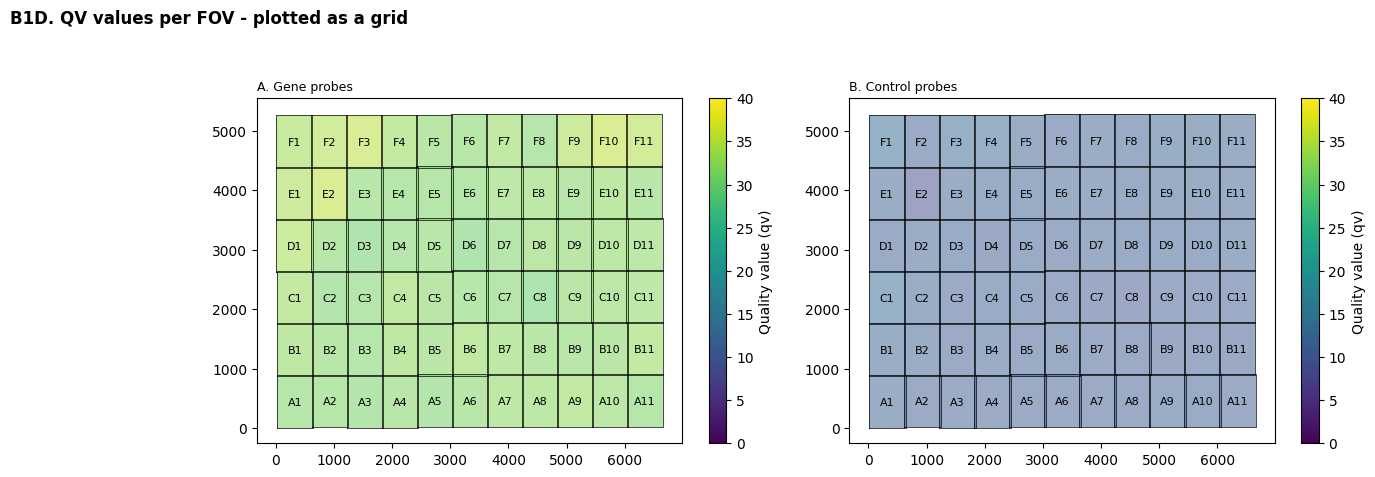

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

fig.suptitle('B1D. QV values per FOV - plotted as a grid', fontsize=12, fontweight='bold', y=1.05, x=0.01)
ppf.fov_plot(processed_data, plot_qv=True, identifier='gene_probes', ax=ax[0])
ax[0].set_title('A. Gene probes', fontsize=9, loc='left')

ppf.fov_plot(processed_data, plot_qv=True, identifier='neg_probes', ax=ax[1])
ax[1].set_title('B. Control probes', fontsize=9, loc='left')

plt.tight_layout()
plt.savefig(out+'script01_figures/figure04_qv_per_fov.jpeg', dpi=300)

ppf.get_memory_usage() ### monitor memory usage

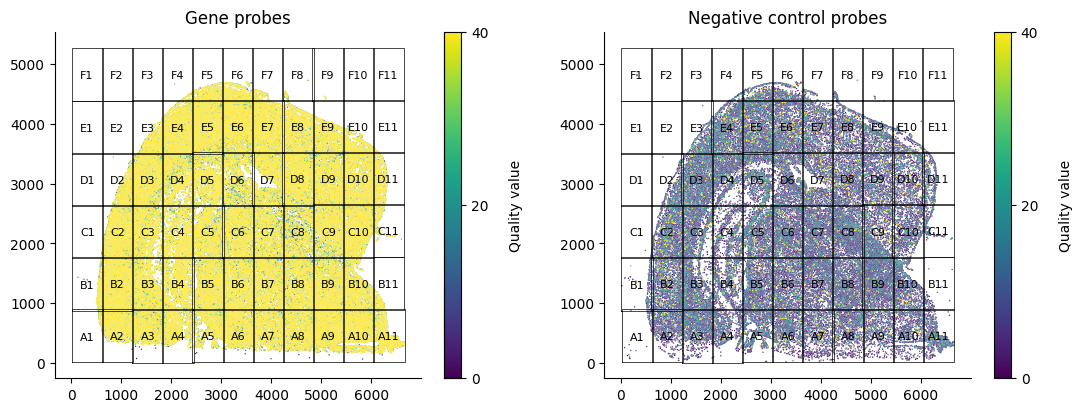

'Memory usage: 5361.98 MB'

<Figure size 640x480 with 0 Axes>

In [12]:
fig.suptitle('B1E. QV values of each transcript - plotted as a grid', fontsize=12, fontweight='bold', y=1.05, x=0.01)
ppf.plot_gene_and_neg_transcripts(processed_data)
plt.savefig(out+'script01_figures/figure05_gene_and_neg_qv_by_transcripts.jpeg', dpi=300)

ppf.get_memory_usage() ### monitor memory usage

B2. NOW WE CAN DECIDE TO CLEAN OUR DATASETS BASED ON
1. Choice of QV cut-off : standard practise is to use QV > 20 but this can be changed
2. Keep all or discard certain FOVs.
3. Check for edge-effects and decide to drop transcripts covering the borders
4. Choose to re-evaluate images (H&E or IF images if necessary) 


In [13]:
"""
The cleaned data is then used to create the gene matrix, control matrix, counts matrix and cell centroid matrix 
Here, it involves removing low quality transcripts and assigning the transcripts to the cells based on the cell segmentation from the standard xenium clear_output
We still keep the negative control values as a separate matrix

However the 3 matrices that we will bring forward to the next lesson are
1. gene matrix
2. counts matrix
3. cell centroid matrix
"""

df_counts, gene_mtx, neg_mtx, centroids = ppf.clean_processed_tf(processed_data)

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 5498.61 MB'

Look at each matrix and note how these are now your standard single cell matrices that you are probably used to working with.

In [14]:
gene_mtx 

,2010300C02Rik,Abca7,Acsbg1,Acta2,Acvrl1,Adamts2,Adamtsl1,Adgrl4,Aldh1a2,Aldh1l1,...,Unc13c,Vat1l,Vcan,Vim,Vip,Vwc2l,Wfs1,Zfp366,Zfp536,Zfpm2
aaabiggh-1,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
aaacfoel-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0
aaaeefil-1,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
aaaehidd-1,6.0,2.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,8.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,2.0
aaagcbkg-1,2.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,...,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oindmjog-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
oinecaba-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
oinehfmf-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oinemiil-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
centroids

,centroid_x,centroid_y
aaabiggh-1,832.555969,755.292725
aaacfoel-1,822.510498,769.635193
aaaeefil-1,831.431396,780.094727
aaaehidd-1,853.754822,774.527405
aaagcbkg-1,820.702148,798.986694
...,...,...
oindmjog-1,5076.077148,4449.942383
oinecaba-1,5071.904785,4459.243164
oinehfmf-1,5256.072266,4369.897461
oinemiil-1,5252.048828,4374.945312


Let's now evaluate the number of genes expressed by each cell and plot a distribution plot for it

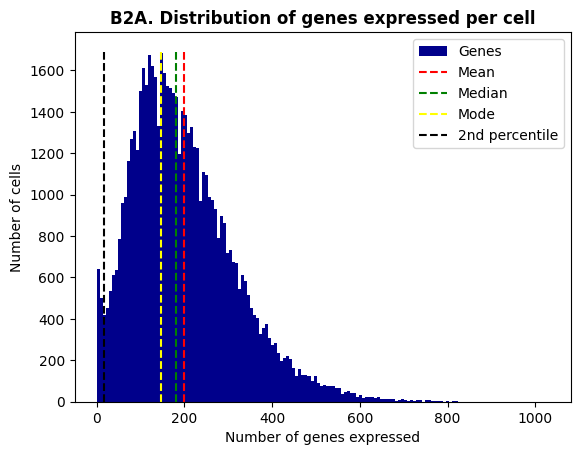

In [16]:
### evaluate the distribution of genes expressed per cell
gene_counts = gene_mtx.sum(axis=1)
gene_counts.plot(kind='hist', bins=150, color='darkblue', edgecolor=None)
plt.vlines(gene_counts.mean(), 0, 1700, color='red', linestyle='dashed')
plt.vlines(gene_counts.median(), 0, 1700, color='green', linestyle='dashed')
plt.vlines(gene_counts.mode(), 0, 1700, color='yellow', linestyle='dashed')
plt.vlines(gene_counts.quantile(0.02), 0, 1700, color='black', linestyle='dashed')


### label the plot
plt.title('B2A. Distribution of genes expressed per cell', fontsize=12, fontweight='bold')
plt.xlabel('Number of genes expressed')
plt.ylabel('Number of cells')
plt.legend(['Genes', 'Mean', 'Median', 'Mode', '2nd percentile'], loc='upper right')

plt.savefig(out+'script01_figures/figure06_genes_per_cell.jpeg', dpi=300)

In [17]:
gene_counts.quantile(0.02)

16.0

Now we can decide what's the minimum number of genes we want to exclude 

In [18]:
df_counts ### this is a slightly longer dataframe with the counts of the gene and control probes

,gene_counts,neg_counts
aaabiggh-1,554.0,0.0
aaacfoel-1,291.0,0.0
aaaeefil-1,220.0,1.0
aaaehidd-1,1029.0,0.0
aaagcbkg-1,453.0,1.0
...,...,...
gedjloba-1,0.0,1.0
gehebjbb-1,0.0,1.0
iecpmknl-1,0.0,1.0
jainilhg-1,0.0,1.0


Here, we will use the df_counts file to plot the distrbution of control and gene-derived transcript distribution. We can clearly see that using a threshold of discarding any cell having less than 10 cells is reasonable.

'Memory usage: 5535.24 MB'

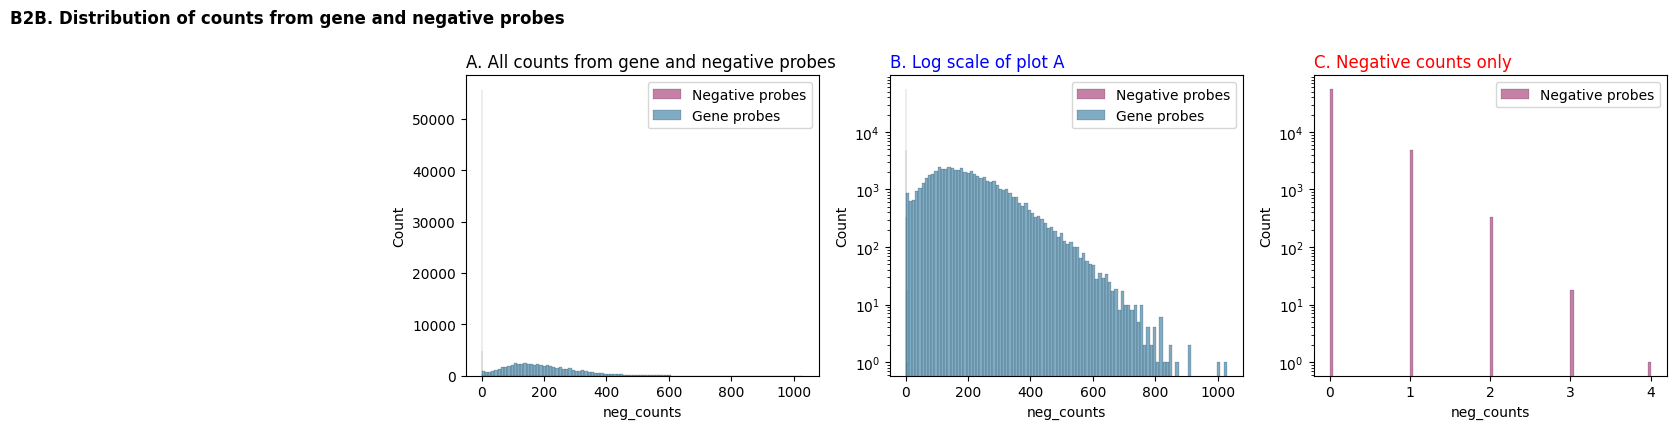

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15.5, 3.9))
ax = sns.histplot(df_counts, x='neg_counts', bins=100, color='#8a034f', alpha=0.5, ax=axes[0], linewidth=0.1)
ax = sns.histplot(df_counts, x='gene_counts', bins=100, alpha=0.5, ax=axes[0], color='#005a8a', linewidth=0.1)
ax.set_title('A. All counts from gene and negative probes', loc='left', color='black')
ax.legend(['Negative probes', 'Gene probes'])

ax = sns.histplot(df_counts, x='neg_counts', bins=100, color='#8a034f', alpha=0.5, ax=axes[1], linewidth=0.1)
ax = sns.histplot(df_counts, x='gene_counts', bins=100, alpha=0.5, ax=axes[1], color='#005a8a', linewidth=0.1)
ax.set_yscale('log')
ax.set_title('B. Log scale of plot A' , loc='left', color='blue')
ax.legend(['Negative probes', 'Gene probes'])

ax = sns.histplot(df_counts, x='neg_counts', bins=100, color='#8a034f', alpha=0.5, ax=axes[2], linewidth=0.1)
#sns.histplot(df_counts, x='gene_counts', bins=100, alpha=0.5, ax=ax, color='blue')
ax.set_yscale('log')
ax.set_title('C. Negative counts only', loc='left', color='red')
ax.legend(['Negative probes'])

fig.suptitle('B2B. Distribution of counts from gene and negative probes', fontsize=12, fontweight='bold', y=1.05, x=0.01)
plt.savefig(out+'script01_figures/figure07_histogram_counts.jpeg', dpi=300)

ppf.get_memory_usage() ### monitor memory usage

Remember, remember & remember to save your file.

In [20]:
os.makedirs(out+'script01_objects/', exist_ok=True)
df_counts.to_csv(out+'script01_objects/df_counts.csv', index=True)
gene_mtx.to_csv(out+'script01_objects/gene_mtx.csv', index=True)
neg_mtx.to_csv(out+'script01_objects/neg_mtx.csv', index=True)
centroids.to_csv(out+'script01_objects/centroids.csv', index=True)

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 5540.24 MB'

* Next, let's finally create single cell like object that will store our gene matrix, counts matrix and centroid information in the right order.
* In this workshop, we will use the AnnData container to store all our frames. In practise, you can use any S4 container to do so - as long as you slot them in properly.
* In the next steps, we will perform the final clean-up  by removing low transcript cells (as determined above) and also to take note of the median/mean expression of transcripts.

In [21]:
"""
The prepare_adata function is a wrapper that will process the centroid matrix, gene matrix and counts matrix properly to create an anndata object
This wrapper also will remove cells that contain less thatn a certain number of counts and genes - based on our analysis above

"""

adata = ppf.prepare_adata(gene_mtx, df_counts ,centroids, min_counts=9, min_cells=3)
adata

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 5864.69 MB'

In [22]:
adata.var

,genes,n_cells
2010300C02Rik,2010300C02Rik,25330
Abca7,Abca7,9272
Acsbg1,Acsbg1,23048
Acta2,Acta2,4659
Acvrl1,Acvrl1,3933
...,...,...
Vwc2l,Vwc2l,6037
Wfs1,Wfs1,19130
Zfp366,Zfp366,1698
Zfp536,Zfp536,16920


'Memory usage: 5738.73 MB'

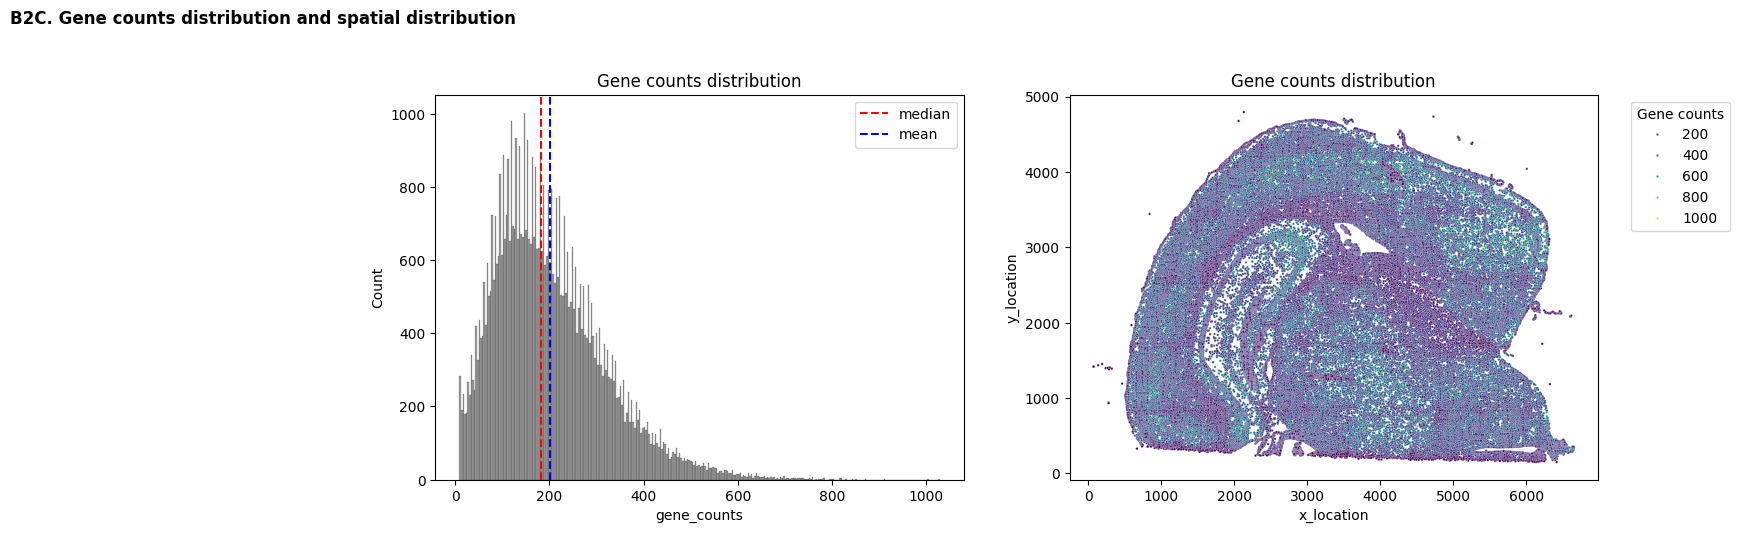

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

### understand certain factors surrounding normalization
median = adata.obs['gene_counts'].median()
mean = adata.obs['gene_counts'].mean()

adata.uns['median'] = median
adata.uns['mean'] = mean

### first look at counts distribution
ax = sns.histplot(adata.obs['gene_counts'], bins=300, color='gray', ax=axes[0])
ax.axvline(median, color='red', linestyle='--', label='median')
ax.axvline(mean, color='blue', linestyle='--', label='mean')
ax.legend()
ax.set_title('Gene counts distribution')

adata.obs['gene_counts'] = adata.obs['gene_counts'].sort_values(ascending=True)
ax = sns.scatterplot(data=adata.obs, x='x_location', y='y_location', hue='gene_counts', palette='viridis', s=3, ax=axes[1])
ax.set_title('Gene counts distribution')
ax.legend(title='Gene counts', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle('B2C. Gene counts distribution and spatial distribution', fontsize=12, fontweight='bold', y=1.05, x=0.01)
plt.savefig(out+'script01_figures/figure08_gene_counts_distribution.jpeg', dpi=300)

ppf.get_memory_usage() ### monitor memory usage

In [24]:
### save your adata
adata.write(out+'script01_objects/adata.h5ad')
